# House Prices Estimator

__Note:__ It's a competition from __Kaggle.com__ and the input data was retrieved from there.


## Data Analysis

In [3]:
import numpy as np
import pandas as pd

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
data = pd.concat([train, test])

#size of training dataset
train_samples = train.shape[0]

#print some of them
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [4]:
# remove the Id feature
data.drop(['Id'],1, inplace=True);

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

### First problem
* The training and test datasets have almost the __same size__.

In [6]:
print("Size training: {}".format(train.shape[0]))
print("Size testing: {}".format(test.shape[0]))

Size training: 1460
Size testing: 1459


### Selecting _only_ numeric columns (by now) 

In [7]:
datanum = data.select_dtypes([np.number])

### Find if there's null values

In [8]:
datanum.columns[datanum.isnull().any()].tolist()

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'SalePrice',
 'TotalBsmtSF']

In [9]:
#number of row without NaN
print(datanum.shape[0] - datanum.dropna().shape[0])

1798


In [152]:
#list of columns with NaN
datanum.columns[datanum.isnull().any()].tolist()

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'SalePrice',
 'TotalBsmtSF']

In [259]:
#Filling with the mean
datanum_no_nan = datanum.fillna(datanum.dropna().mean())

#check
datanum_no_nan.columns[datanum_no_nan.isnull().any()].tolist()

[]

### Normalizing

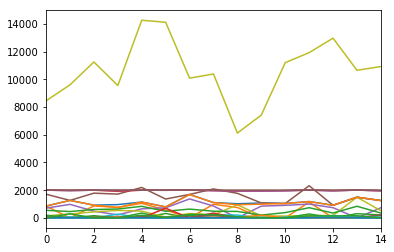

In [260]:
import matplotlib.pyplot as plt
%matplotlib inline

datanum_no_nan.drop(['SalePrice'], axis=1).head(15).plot(legend=False);

In [315]:
#Squeeze the data to [0,1]
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
columns = datanum_no_nan.columns.drop('SalePrice')

print("Features: {}".format(columns))

Features: Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')


Train shape: (2919, 37)


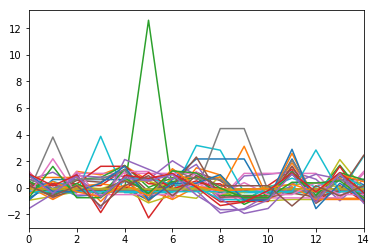

In [316]:
#make a copy
data_norm = datanum_no_nan

data_norm[columns] = scaler.fit_transform(datanum_no_nan[columns])
print("Train shape: {}".format(data_norm.shape))

data_norm.drop(['SalePrice'], axis=1).head(15).plot(legend=False);

#### Selecting good features...

In [317]:
# Correlation features
data_norm.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.547865
GrLivArea       0.518693
GarageCars      0.444010
GarageArea      0.437270
TotalBsmtSF     0.431030
1stFlrSF        0.421430
FullBath        0.394865
TotRmsAbvGrd    0.388821
YearBuilt       0.368417
Name: SalePrice, dtype: float64

In [318]:
high_corr_feat_names = data_norm.corr()['SalePrice'].sort_values(ascending=False).head(10).axes[0].tolist()
high_corr_feat_names.remove('SalePrice')
data_norm_high_corr = data_norm[high_corr_feat_names]

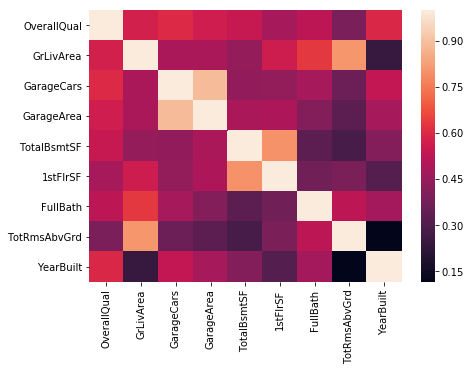

In [319]:
#heatmap
import seaborn as sns

fig = plt.figure(figsize=(7, 5))
sns.heatmap(data_norm_high_corr.corr());

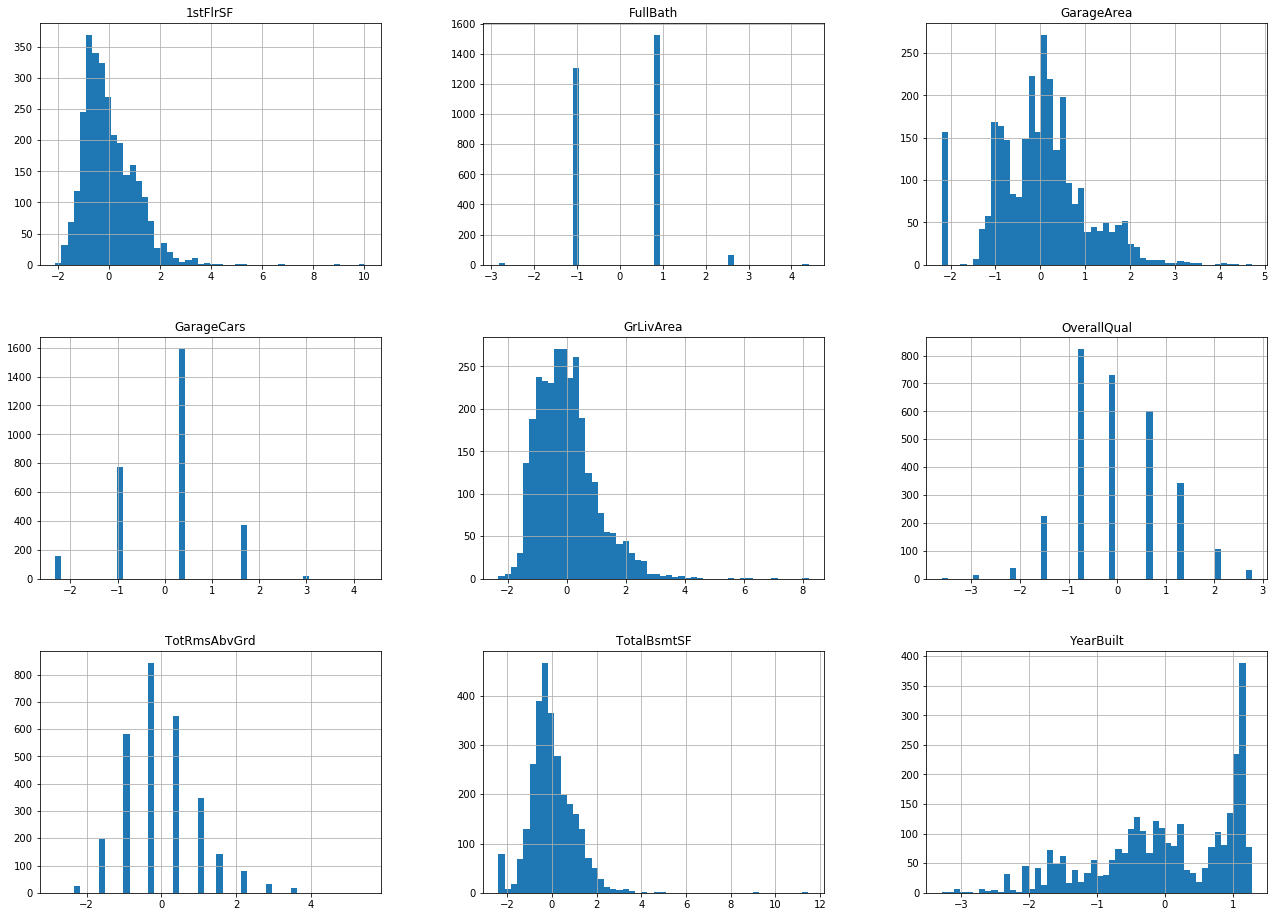

In [320]:
#plotting distributions of numeric features
data_norm_high_corr.hist(bins=50, figsize=(22,16));

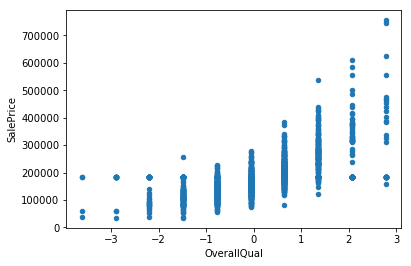

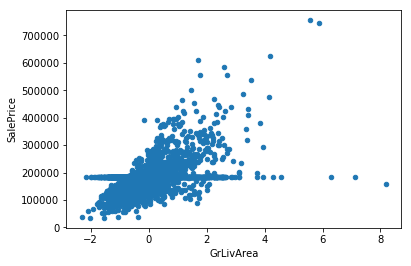

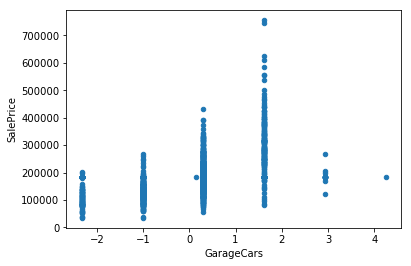

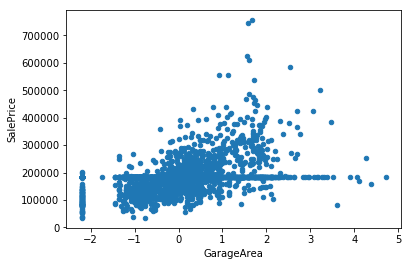

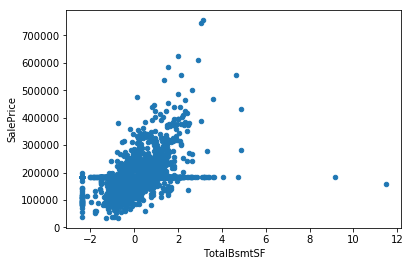

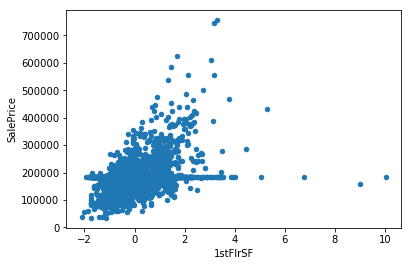

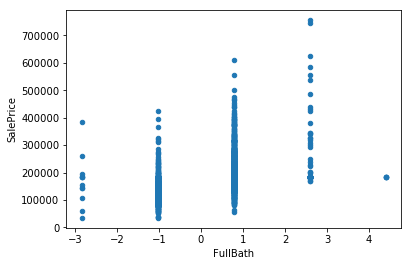

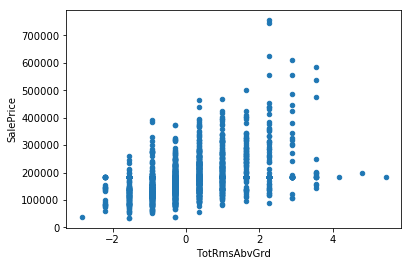

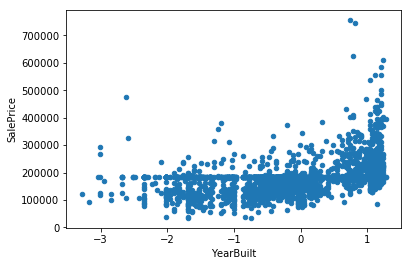

In [321]:
# Relationships between correlated features

for feature in high_corr_feat_names:
    data_norm.plot.scatter(feature, 'SalePrice');

### Splitting dataset in train and test (getting batches)

#### KFold

In [322]:
from sklearn.model_selection import KFold

y = np.array(data_all['SalePrice'])
X = np.array(data_norm_high_corr)

#split by idx
idx = train_samples
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

print("Shape X train: {}".format(X_train.shape))
print("Shape y train: {}".format(y_train.shape))
print("Shape X test: {}".format(X_test.shape))
print("Shape y test: {}".format(y_test.shape))

kf = KFold(n_splits=3, random_state=9, shuffle=True)
print(kf)

Shape X train: (1460, 9)
Shape y train: (1460,)
Shape X test: (1459, 9)
Shape y test: (1459,)
KFold(n_splits=3, random_state=9, shuffle=True)


#### Anomaly Detection

In [323]:
#plotting PCA
from sklearn.decomposition import PCA

def plotPCA(X, y):
    pca = PCA(n_components=1)
    X_r = pca.fit(X).transform(X)
    plt.plot(X_r, y, 'x')

/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:161: RuntimeWarning: Warning! det > previous_det (-13.976040973603045 > -42.710586265298275)
  % (det, previous_det), RuntimeWarning)


(1314, 9)
(1314,)


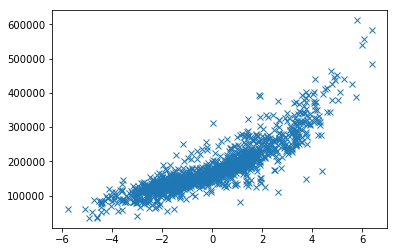

In [324]:
from sklearn.covariance import EllipticEnvelope

# fit the model
ee = EllipticEnvelope(contamination=0.1,
                      assume_centered=True,
                      random_state=9)
ee.fit(X_train)
pred = ee.predict(X_train)

X_train = X_train[pred == 1]
y_train = y_train[pred == 1]
print(X_train.shape)
print(y_train.shape)

#after removing anomalies
plotPCA(X_train, y_train)

### Models

In [339]:
# Gradient boosting
from sklearn import ensemble

params = {'n_estimators': 100, 'max_depth': X_train.shape[1], 'min_samples_split': 5,
          'learning_rate': 0.1, 'loss': 'ls', 'random_state':9, 'warm_start':True}

gbr = ensemble.GradientBoostingRegressor(**params)

batch = 0
for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    #training
    gbr.fit(X_t, y_t)

    #calculate costs
    t_error = mean_squared_error(y_t, gbr.predict(X_t))**0.5
    v_error = mean_squared_error(y_v, gbr.predict(X_v))**0.5
    print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
          .format(batch, t_error, v_error, gbr.score(X_v, y_v)))
    batch += 1

#Scores
print("Training score: {:.4f}".format(gbr.score(X_train, y_train)))

0) Training error: 1494.57  Validation error: 31055.68 Score: 0.81
1) Training error: 21983.61  Validation error: 1537.61 Score: 1.00
2) Training error: 21986.58  Validation error: 1450.24 Score: 1.00
Training score: 0.9394


In [340]:
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=X_train.shape[1]),
                        n_estimators=100, random_state=9)

batch = 0
for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    #training
    abr.fit(X_t, y_t)

    #calculate costs
    t_error = mean_squared_error(y_t, abr.predict(X_t))**0.5
    v_error = mean_squared_error(y_v, abr.predict(X_v))**0.5
    print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
          .format(batch, t_error, v_error, abr.score(X_v, y_v)))
    batch += 1

#Scores
print("Training score: {:.4f}".format(abr.score(X_train, y_train)))

0) Training error: 6843.07  Validation error: 29456.53 Score: 0.83
1) Training error: 6907.67  Validation error: 29379.42 Score: 0.86
2) Training error: 6949.64  Validation error: 27748.02 Score: 0.84
Training score: 0.9458


### Stacked model

In [327]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=9)
sclr = preprocessing.StandardScaler()

def stack_training(X, y):
    X1 = gbr.predict(X)
    X2 = abr.predict(X)
    Xt = np.array([X1, X2]).T
    Xt = sclr.fit_transform(Xt)
    lr.fit(Xt, y)

def stack_predict(X, verbose=False):
    X1 = gbr.predict(X)
    X2 = abr.predict(X)
    Xt = np.array([X1, X2]).T
    Xt = sclr.transform(Xt)
    return lr.predict(Xt)

#
batch = 0
kf = KFold(n_splits=3, random_state=9)

for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    #training
    stack_training(X_t, y_t)

    #calculate costs
    t_error = mean_squared_error(y_t, stack_predict(X_t))**0.5
    v_error = mean_squared_error(y_v, stack_predict(X_v))**0.5
    print("{}) Training error: {:.2f}  Validation error: {:.2f}".format(batch, t_error, v_error))
    batch += 1

rmse = mean_squared_error(y_train, stack_predict(X_train, True))**0.5
print("RMSE: {:.4f}".format(rmse))

0) Training error: 42678.53  Validation error: 41508.32
1) Training error: 37849.59  Validation error: 40465.43
2) Training error: 48734.38  Validation error: 48137.26
RMSE: 48536.1549


### Evaluation

It has to be used the _root mean squared error_, __RMSE__.

In [329]:
from sklearn.metrics import mean_squared_error
import random

RMSE_gbr = mean_squared_error(y_train, gbr.predict(X_train))**0.5
RMSE_abr = mean_squared_error(y_train, abr.predict(X_train))**0.5
RMSE_stack = mean_squared_error(y_train, stack_predict(X_train))**0.5

def avg_predict(X):
    return (gbr.predict(X) + abr.predict(X))/2

predictions = avg_predict(X_train)
RMSE_total = mean_squared_error(y_train, predictions)**0.5

print("RMSE gbr: {:.3f}".format(RMSE_gbr))
print("RMSE abr: {:.3f}".format(RMSE_abr))
print("====")
print("RMSE average: {:.3f}".format(RMSE_total))
print("RMSE stacked: {:.3f}".format(RMSE_stack))

RMSE gbr: 16383.482
RMSE abr: 19692.984
====
RMSE average: 13572.580
RMSE stacked: 48536.155


## Get Predictions

In [336]:
import os

predict = avg_predict(X_test)
#predict = stack_predict(X_test)
file = "Id,SalePrice" + os.linesep

startId = 1461
for i in range(len(X_test)):
    file += "{},{}".format(startId, (int)(predict[i])) + os.linesep
    startId += 1

#print(file)

In [334]:
# Save to file
with open('attempt.txt', 'w') as f:
    f.write(file)